# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Let's get the data!

In [3]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [7]:
total_words = len(tokenizer.word_index) + 1
print(total_words)

3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

Explanation:
tokenizer.texts_to_sequences([line])[0]: Converts the sentence line into a list of integers.
n-gram sequence generation: The for-loop generates all possible n-gram sequences from each sentence.
Store in input_sequences: Each n-gram sequence is appended to the input_sequences list.


In [10]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
        
    for i in range(1, len(token_list) + 1):
        n_gram_sequence = token_list[:i]
        input_sequences.append(n_gram_sequence)

print(input_sequences[:5])

[[878], [3], [3, 2], [3, 2, 313], [3, 2, 313, 1375]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

Explanation:
max([len(seq) for seq in input_sequences]): Calculates the length of the longest sequence in input_sequences.
pad_sequences(..., maxlen=max_sequence_len, padding='pre'): Pads all sequences to the length of the longest one, adding zeros at the beginning (because of padding='pre').
Convert to numpy array: This ensures that the padded sequences are stored in a format that's suitable for model training.

In [11]:
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
input_sequences = np.array(input_sequences)
print(f"Shape of input_sequences: {input_sequences.shape}")


Shape of input_sequences: (17805, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [12]:
predictors = input_sequences[:, :-1]
labels = input_sequences[:, -1]

print(predictors.shape)
print(labels.shape)


(17805, 10)
(17805,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

Explanation:
ku.to_categorical(labels, num_classes=total_words): This converts each integer in labels into a one-hot encoded vector of length total_words. The num_classes=total_words ensures the one-hot vectors correspond to the vocabulary size.

Shape verification: The output labels should now have a shape of (number_of_sequences, total_words) where each label is represented by a one-hot encoded vector.

In [13]:
labels = ku.to_categorical(labels, num_classes=total_words)
print(f"Shape of one-hot encoded labels: {labels.shape}")


Shape of one-hot encoded labels: (17805, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

Explanation of the Layers:
Embedding Layer: Maps word indices to dense vectors of size 100. input_length is set to max_sequence_len-1 because the predictors are one word shorter than the padded sequences.
Bidirectional LSTM Layer: Uses 150 units and reads the sequence both forward and backward. return_sequences=True allows this LSTM layer to output the full sequence, needed for subsequent layers.
Dropout Layer: Helps reduce overfitting by randomly setting 20% of the input units to zero during each update.
Second LSTM Layer: Processes the sequence with 100 units, capturing dependencies between words.
Dense Layer (Intermediate): Reduces the number of units to half the vocabulary size and applies ReLU activation. L2 regularization is added to penalize large weights, preventing overfitting.
Dense Layer (Output): Outputs a probability distribution over all words in the vocabulary using softmax activation, predicting the next word in the sequence.

In [14]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

model = Sequential([

    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(total_words, activation='softmax')
])
model.summary()


2024-10-04 13:30:13.506208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 13:30:14.133520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 13:30:14.133881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           337500    
                                                                 
 bidirectional (Bidirection  (None, 10, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1687)              170387    
                                                                 
 dense_1 (Dense)             (None, 3375)              5697000   
                                                        

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

Explanation:
Loss Function (categorical_crossentropy): This is used for multi-class classification problems where the labels are one-hot encoded, which fits your case since each word is represented as a one-hot vector.
Optimizer (Adam): The Adam optimizer is efficient and widely used for training deep learning models because it adapts the learning rate during training.
Metrics (accuracy): The accuracy metric evaluates how often the model's predictions match the true labels.


In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

print("Model compiled successfully!")


Model compiled successfully!


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           337500    
                                                                 
 bidirectional (Bidirection  (None, 10, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1687)              170387    
                                                                 
 dense_1 (Dense)             (None, 3375)              5697000   
                                                        

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [42]:
history = model.fit(predictors, labels, epochs=80, batch_size=64, verbose=1)


Epoch 1/80
279/279 [==============================] - 4s 16ms/step - loss: 2.3057 - accuracy: 0.5963
Epoch 2/80
279/279 [==============================] - 4s 16ms/step - loss: 2.2685 - accuracy: 0.6013
Epoch 3/80
279/279 [==============================] - 5s 16ms/step - loss: 2.2312 - accuracy: 0.6097
Epoch 4/80
279/279 [==============================] - 4s 16ms/step - loss: 2.2058 - accuracy: 0.6154
Epoch 5/80
279/279 [==============================] - 5s 17ms/step - loss: 2.1840 - accuracy: 0.6191
Epoch 6/80
279/279 [==============================] - 4s 16ms/step - loss: 2.1666 - accuracy: 0.6235
Epoch 7/80
279/279 [==============================] - 5s 18ms/step - loss: 2.1357 - accuracy: 0.6289
Epoch 8/80
279/279 [==============================] - 6s 21ms/step - loss: 2.1130 - accuracy: 0.6362
Epoch 9/80
279/279 [==============================] - 5s 18ms/step - loss: 2.0917 - accuracy: 0.6372
Epoch 10/80
279/279 [==============================] - 5s 19ms/step - loss: 2.0790 - accura

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

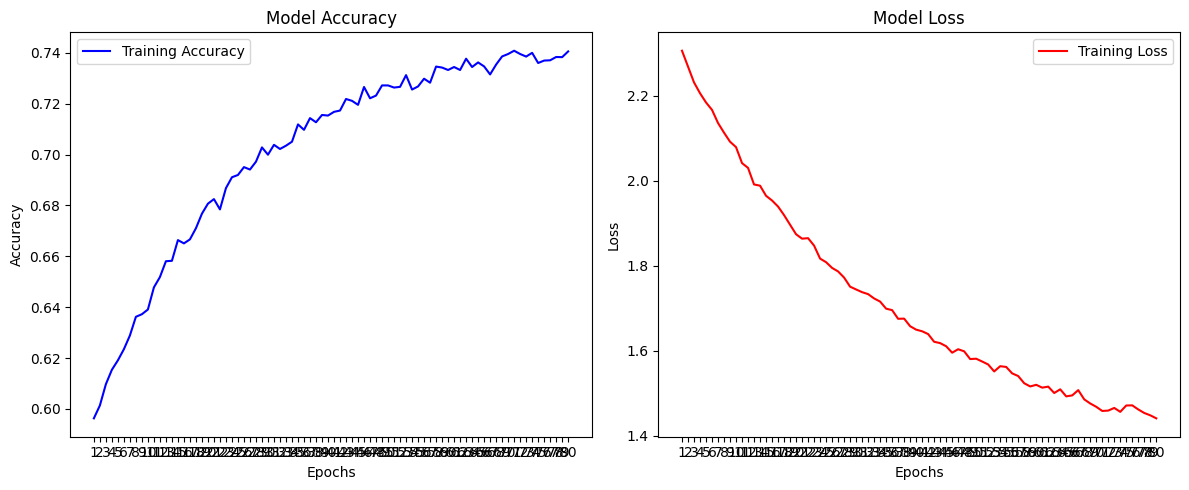

In [43]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)  
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  
plt.legend()

plt.tight_layout()
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [44]:
seed_text = 'I heard you singing in the midnight air'
next_words = 30  


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [45]:
def generate_text(model, seed_text, next_words, tokenizer, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=-1)[0]
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break
        seed_text += " " + output_word

    return seed_text

generated_text = generate_text(model, seed_text, next_words, tokenizer, max_sequence_len)

print("Generated Text:\n", generated_text)


Generated Text:
 I heard you singing in the midnight air in life of mind days dyed allay'd dyed blind blind chest thee blind eye best alone write thee alone thee thee so much hell best rhyme thought should thee away


Experiment with at least 3 different seed_text strings and see what happens!

In [31]:
seed_texts = [
    'All the leaves are brown, and the sky is grey'
    ]

next_words = 15

# Loop through each seed text and generate new text
for seed in seed_texts:
    generated_text = generate_text(model, seed, next_words, tokenizer, max_sequence_len)
    print(f"Generated Text from Seed '{seed}':\n{generated_text}\n")


Generated Text from Seed 'All the leaves are brown, and the sky is grey':
All the leaves are brown, and the sky is grey of told days arising days dearer prove thee last on me perjured thee not not



In [33]:
seed_texts = [
    'Purple haze, all in my brain...'
    ]

next_words = 20

# Loop through each seed text and generate new text
for seed in seed_texts:
    generated_text = generate_text(model, seed, next_words, tokenizer, max_sequence_len)
    print(f"Generated Text from Seed '{seed}':\n{generated_text}\n")


Generated Text from Seed 'Purple haze, all in my brain...':
Purple haze, all in my brain... and stain eyes eyes strong sum new days need done go so so ' young thee mine art bright be



In [34]:
# List of different seed texts to experiment with
seed_texts = [
    'People are strange when you are a stranger'
    ]

# Number of words to generate
next_words = 15

# Loop through each seed text and generate new text
for seed in seed_texts:
    generated_text = generate_text(model, seed, next_words, tokenizer, max_sequence_len)
    print(f"Generated Text from Seed '{seed}':\n{generated_text}\n")


Generated Text from Seed 'People are strange when you are a stranger':
People are strange when you are a stranger dream doth flatter new days need convert convert convert heaven told told good friend of



In [37]:
seed_texts = [
    'I heard you singing in the midnight air.'
    ]

next_words = 15

for seed in seed_texts:
    generated_text = generate_text(model, seed, next_words, tokenizer, max_sequence_len)
    print(f"Generated Text from Seed '{seed}':\n{generated_text}\n")


Generated Text from Seed 'I heard you singing in the midnight air.':
I heard you singing in the midnight air. to make them die but good part sight grow so true woe needing lie '

